# Resample

## Idea 1: Using scipy resample functions
Problems with this is that although the data itself gets downsampled, attributes such as time axis and sampling frequency remain the same.
- resample_poly can downsample only by an integer factor
- resample can downsample for any factor (you just need to specify the number of samples)
- decimate can downsample only by an integer factor

This is important to consider if the data is not just being downsampled by half (10kHz -> 5kHz), but also to other frequencies such as 4kHz.

In [2]:
import numpy as np
from scipy.signal import resample_poly, decimate, resample
from matplotlib import pyplot as plt
import h5py
import dascore as dc
import shutil
from dascore.io.neubrex.utils_das import _is_neubrex as _is_neubrex_das

from scipy.stats import ks_2samp


In [3]:
# Resample Poly
x = np.random.randn(100)
print(x)
y = resample_poly(x,up=1,down=2,axis=0, window=[1])
print(y)

# Resample
y = resample(x, num=len(x)//2)
print(y)

# Decimate
y = decimate(x,q=2,zero_phase=True)
print(y)

[ 0.815733    0.34084586 -0.69719131  1.3044147  -0.22575528 -0.00570253
  1.94577413 -1.24520894 -1.0306152   0.03830259 -0.8111381   0.50232114
 -2.17086761  1.36925563  1.44812813  0.44533686 -0.45289298 -0.47311133
  1.29709471 -0.21255418  1.92126757  0.42247778  0.83342759 -1.42620152
 -0.91154796 -1.58920122  1.20000401 -0.06958711 -0.64931103 -0.75487912
 -0.91736358  0.24713502 -2.07858465 -0.44496463  0.73698635 -1.61419712
  0.52171754 -0.95324166  0.57369529  0.69623626 -0.066057   -0.4117457
  0.05536768  0.52531395 -0.52176893  0.49308869  0.54114246 -0.33927997
  0.42964091  0.34677869 -0.30480653 -1.44298907 -0.42050248  0.71813913
 -0.44216818  0.10366918 -0.11583441 -1.21114747 -0.58001028  0.13121552
 -0.75798548 -0.72878973 -0.83806368  1.65735751 -1.04891307  0.125201
 -0.36433849  1.31831764 -2.19967929 -0.10071813 -0.0504577   0.84020844
 -1.74753088  1.41213781  0.5934787   1.04297447 -0.43523325 -0.31876082
 -0.48691049 -1.34700607  1.76969256 -0.05476384 -0.50

In [4]:
# Method 1: Basic resampling of hd5 file
method1_path = 'example_data/16B_StrainRate_20240407T072116+0000_34572_method1.h5'
og_path = 'example_data/16B_StrainRate_20240407T072116+0000_34572.h5'

shutil.copy2(og_path, method1_path)

with h5py.File(method1_path, 'r+') as f:
    dataset = f['Acoustic']
    resampled_dataset = resample(dataset, num=dataset.shape[0]//2, axis=0)
    # resampled_dataset = resample_poly(dataset, up=1, down=2, axis=0)
    dataset.resize(resampled_dataset.shape)
    dataset[...] = resampled_dataset
    dataset.attrs.modify('TimeSamplingInterval(seconds)', dataset.attrs['TimeSamplingInterval(seconds)']*2)
    dataset.attrs.modify('InterrogationRate(Hz)', dataset.attrs['InterrogationRate(Hz)']/2)

    # for key in dataset.attrs:
        # print(f"{key}: {dataset.attrs[key]}")

In [53]:
# Method 2: Concatenate three patches, filter, and decimate and then take only the middle one
file1_path = 'example_data/16B_StrainRate_20240407T072116+0000_34572.h5'
file2_path = 'example_data/16B_StrainRate_20240407T072128+0000_34573.h5'
file3_path = 'example_data/16B_StrainRate_20240407T072140+0000_34574.h5'
file2_path_m2 = 'example_data/16B_StrainRate_20240407T072128+0000_34573_method2.h5'

shutil.copy2(file2_path, file2_path_m2)

f1 = h5py.File(file1_path, 'r')
f2 = h5py.File(file2_path_m2, 'r+')
f3 = h5py.File(file3_path, 'r')

dataset1 = f1['Acoustic']
dataset2 = f2['Acoustic']
dataset3 = f3['Acoustic']

datasets_data = np.concatenate([dataset1, dataset2, dataset3], axis=0)
data_downsampled = resample(datasets_data, num=datasets_data.shape[0]//2, axis=0)
# data_downsampled = resample_poly(datasets_data, up=1, down=2, axis=0)
data_downsampled = data_downsampled[dataset1.shape[0]//2:dataset1.shape[0]//2+dataset2.shape[0]//2]

dataset2.resize(data_downsampled.shape)
dataset2[...] = data_downsampled
dataset2.attrs.modify('TimeSamplingInterval(seconds)', dataset2.attrs['TimeSamplingInterval(seconds)']*2)
dataset2.attrs.modify('InterrogationRate(Hz)', dataset2.attrs['InterrogationRate(Hz)']/2) 

f1.close()
f2.close()
f3.close()

In [6]:
# Check to see size
with h5py.File(og_path, 'r') as f:
    dataset = f['Acoustic']
    print("Original: ", dataset.shape)

with h5py.File(method1_path, 'r') as f:
    dataset = f['Acoustic']
    print("Method 1: ", dataset.shape)

with h5py.File(file2_path_m2, 'r') as f:
    dataset = f['Acoustic']
    print("Method 2: ", dataset.shape)

Original:  (120000, 1496)
Method 1:  (60000, 1496)
Method 2:  (60000, 1496)


In [7]:
# Load the resampled file with dascore to check if the file attributes are still valid
# Original file
print("Original file: ", og_path)
patch_og = dc.spool(og_path)[0].transpose()
# patch_og.viz.waterfall(show=True, scale=0.1)

print(dc.get_format(og_path))
print(patch_og.attrs)

# Method 1: Visualization
print("Method 1 file: ", method1_path)
patch = dc.spool(method1_path)[0].transpose()
# patch.viz.waterfall(show=True, scale=0.1)
# patch.attrs.coords['time']

print(dc.get_format(method1_path))
print(patch.attrs)

# Method 2: Visualization
print("Method 2 file: ", file2_path_m2)
patch_m2 = dc.spool(file2_path_m2)[0].transpose()
# patch_m2.viz.waterfall(show=True, scale=0.1)

print(dc.get_format(file2_path_m2))
print(patch_m2.attrs)

# Validation: Check if dascore's decimate function leads to the same results
print("Dascore decimate")
decimated_patch = patch_og.decimate(time=2)
# decimated_patch.viz.waterfall(show=True, scale=0.1)

print(decimated_patch.attrs)

Original file:  example_data/16B_StrainRate_20240407T072116+0000_34572.h5
('NeubrexDAS', '1')
data_type='' data_category='' data_units=<Quantity(1.0, 'microstrain / second')> instrument_id='S236106002001' acquisition_id='' tag='' station='' network='' history=() dims='distance,time' coords=<FrozenDict {'time': CoordSummary(dtype='datetime64', min=numpy.datetime64('2024-04-07T07:21:16.844683900'), max=numpy.datetime64('2024-04-07T07:21:28.844463901'), step=numpy.timedelta64(99999,'ns'), units=<Quantity(1, 'second')>), 'distance': CoordSummary(dtype='float32', min=1749.129638671875, max=3275.6613731384277, step=1.0210914611816406, units=<Quantity(1, 'meter')>)}> api=None filed_name='' well_id='' well_name='' well_bore_id='' gauge_length=1.0210915 index_of_refraction=1.468 phase_to_strain=-0.10775734 instrument_model='NBX-S4110' distance_decimation_filter=1 time_decimation_filter=1
Method 1 file:  example_data/16B_StrainRate_20240407T072116+0000_34572_method1.h5
('NeubrexDAS', '1')
data_t

Original Signal
Method 1 Signal
Method 2 Signal
Dascore Decimate


Text(0.5, 1.0, 'Dascore Decimate')

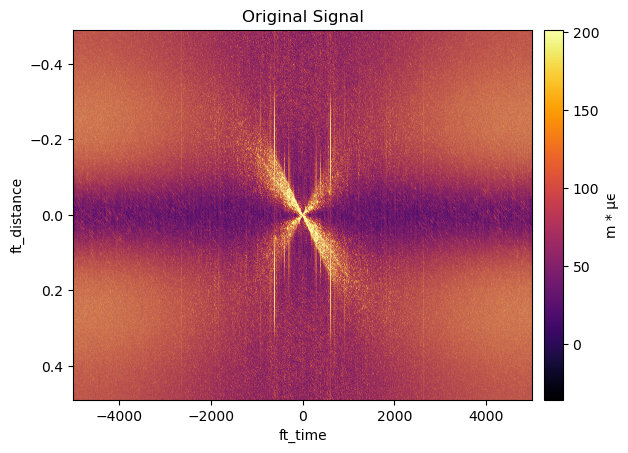

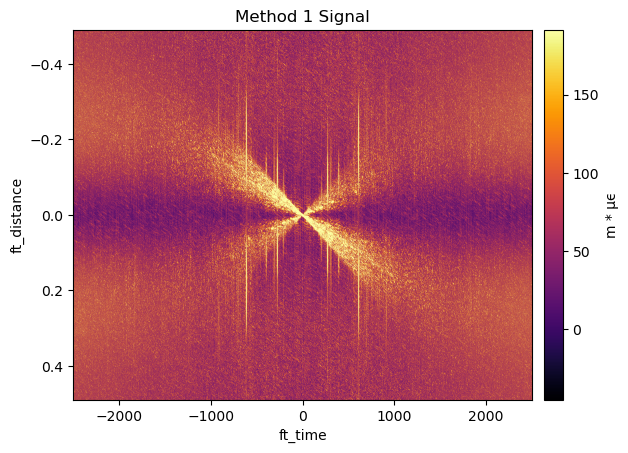

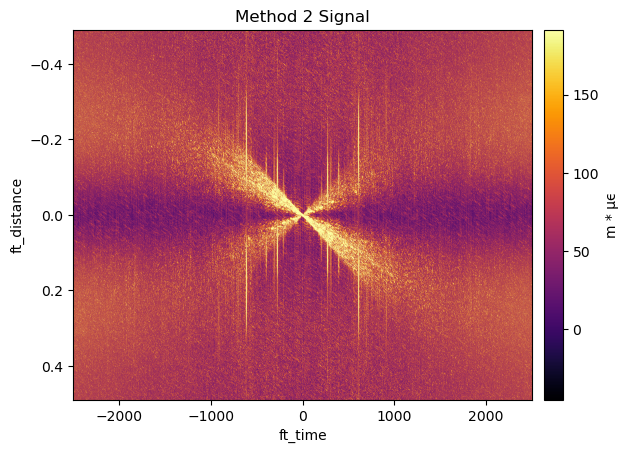

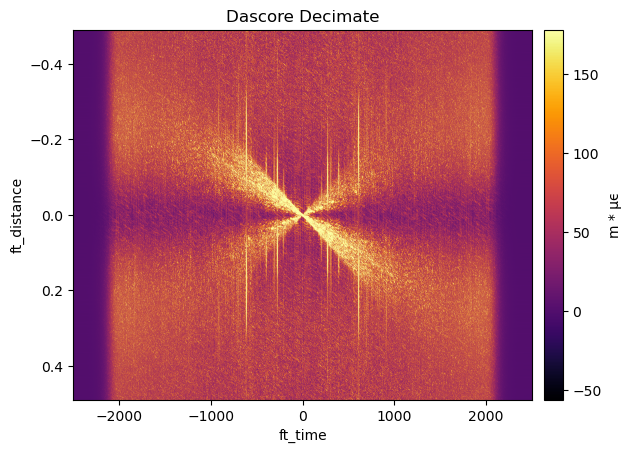

In [8]:
# Frequency analysis of the downsampled signals
# 1. Original
print('Original Signal')
fk_patch = patch_og.dft(patch.dims)
ax = fk_patch.abs().viz.waterfall(scale=0.1, cmap='inferno')
ax.set_title('Original Signal')

# 2. Method 1
print('Method 1 Signal')
fk_patch = patch.dft(patch.dims)
ax = fk_patch.abs().viz.waterfall(scale=0.1, cmap='inferno')
ax.set_title('Method 1 Signal')

# 3. Method 2
print('Method 2 Signal')
fk_patch = patch_m2.dft(patch.dims)
ax = fk_patch.abs().viz.waterfall(scale=0.1, cmap='inferno')
ax.set_title('Method 2 Signal')

# 4. Dascore decimate
print('Dascore Decimate')
fk_patch = decimated_patch.dft(patch.dims)
ax = fk_patch.abs().viz.waterfall(scale=0.1, cmap='inferno')
ax.set_title('Dascore Decimate')

Original Signal


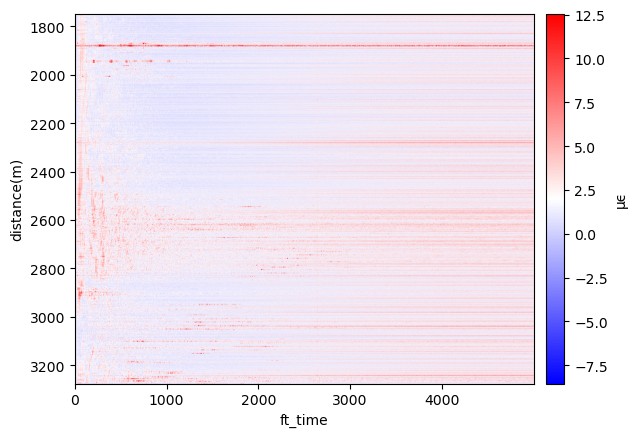

Method 1 Signal


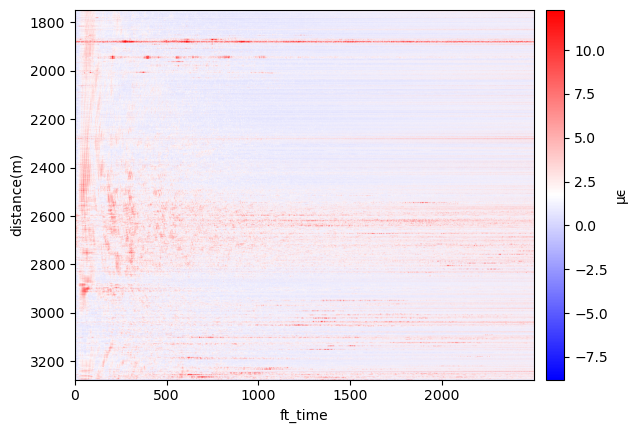

Method 2 Signal


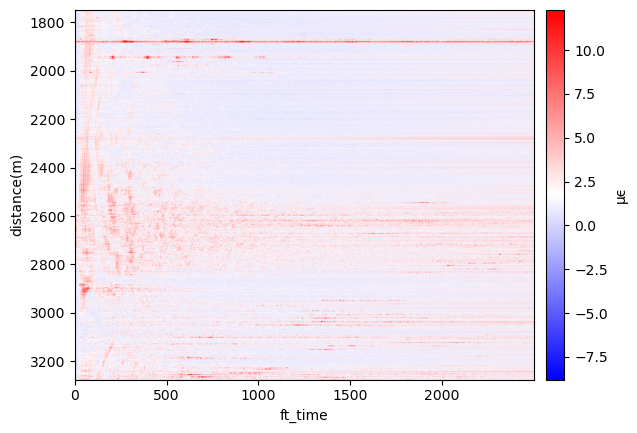

Dascore Decimate


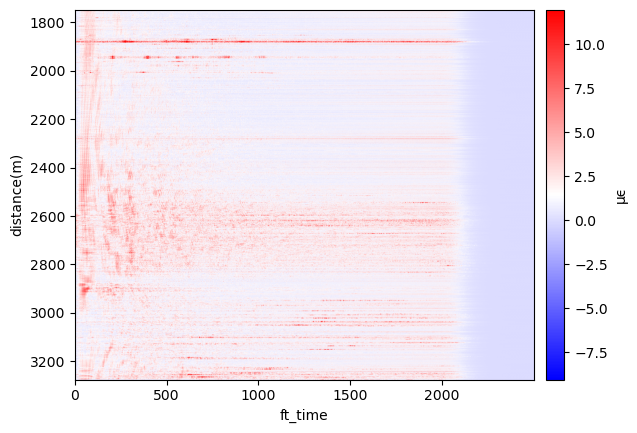

Text(0.5, 1.0, 'Dascore Decimate')

In [9]:
# Frequency analysis channel-wise
# 1. Original
print('Original Signal')
freq_patch_og = patch_og.dft(dim="time").abs()
freq_coords = freq_patch_og.coords.get_array("ft_time")
freq_patch_og = freq_patch_og.select(ft_time=(0, None))
ax = freq_patch_og.viz.waterfall(show=True, scale=0.1)
ax.set_title('Original Signal')

# 2. Method 1
print('Method 1 Signal')
freq_patch_m1 = patch.dft(dim="time").abs()
freq_coords = freq_patch_m1.coords.get_array("ft_time")
freq_patch_m1 = freq_patch_m1.select(ft_time=(0, None))
ax = freq_patch_m1.viz.waterfall(show=True, scale=0.1)
ax.set_title('Method 1 Signal')

# 3. Method 2
print('Method 2 Signal')
freq_patch_m2 = patch_m2.dft(dim="time").abs()
freq_coords = freq_patch_m2.coords.get_array("ft_time")
freq_patch_m2 = freq_patch_m2.select(ft_time=(0, None))
ax = freq_patch_m2.viz.waterfall(show=True, scale=0.1)
ax.set_title('Method 2 Signal')

# 4. Dascore decimate
print('Dascore Decimate')
freq_patch_dc = decimated_patch.dft(dim="time").abs()
freq_coords = freq_patch_dc.coords.get_array("ft_time")
freq_patch_dc = freq_patch_dc.select(ft_time=(0, None))
ax = freq_patch_dc.viz.waterfall(show=True, scale=0.1)
ax.set_title('Dascore Decimate')

In [10]:
# Fourier spectrum error
# 1. Method 1
error1 = np.linalg.norm(freq_patch_og.data[:,:freq_patch_og.shape[1]//2] - freq_patch_m1.data)
print("Method 1 Error: ", error1)

# 2. Method 2
error2 = np.linalg.norm(freq_patch_og.data[:,:freq_patch_og.shape[1]//2] - freq_patch_m2.data)
print("Method 2 Error: ", error2)

# 3. Dascore Decimate
error3 = np.linalg.norm(freq_patch_og.data[:,:freq_patch_og.shape[1]//2] - freq_patch_dc.data)
print("Dascore Decimate Error: ", error3)

Method 1 Error:  0.0758856087084159
Method 2 Error:  56.289348164059774
Dascore Decimate Error:  5704.959075475137


In [11]:
# Upsample and compute reconstruction error
# 1. Method 1
recon1 = resample_poly(patch.data, up=2, down=1, axis=1)
error1 = np.linalg.norm(patch_og.data - recon1)

# 2. Method 2
recon2 = resample_poly(patch_m2.data, up=2, down=1, axis=1)
error2 = np.linalg.norm(patch_og.data - recon2)

# 3. Dascore decimate
recon3 = resample_poly(decimated_patch.data, up=2, down=1, axis=1)
error3 = np.linalg.norm(patch_og.data - recon3)

print("Method 1 error: ", error1)
print("Method 2 error: ", error2)
print("Dascore decimate error: ", error3)

Method 1 error:  749658.94
Method 2 error:  749660.0
Dascore decimate error:  780450.8


In [12]:
# Error on on values that exist in upsampled signal
error1 = np.linalg.norm(patch_og.data[:,::2] - patch.data)
print("Method 1 error: ", error1, error1/patch.data.size)

error2 = np.linalg.norm(patch_og.data[:,::2] - patch_m2.data)
print("Method 2 error: ", error2, error2/patch_m2.data.size)

error3 = np.linalg.norm(patch_og.data[:,::2] - decimated_patch.data)
print("Dascore decimate error: ", error3, error3/decimated_patch.data.size)

Method 1 error:  528016.2 0.005882533283199643
Method 2 error:  528018.1 0.0058825548685383245
Dascore decimate error:  553194.94 0.006163045203877005


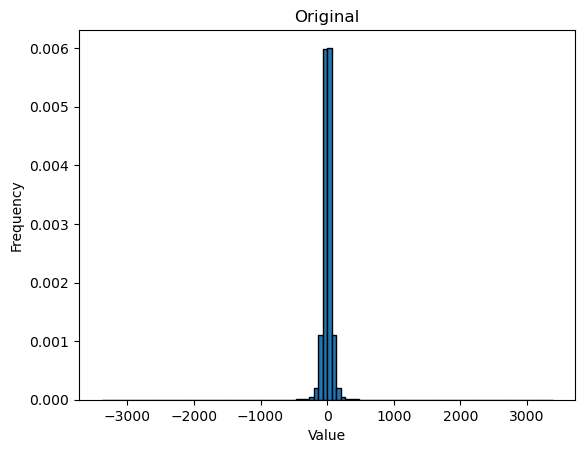

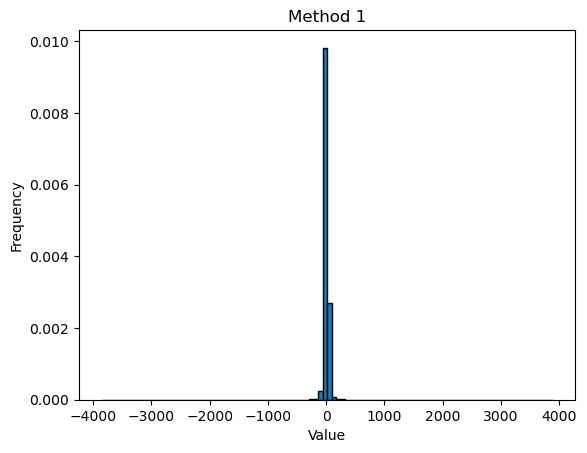

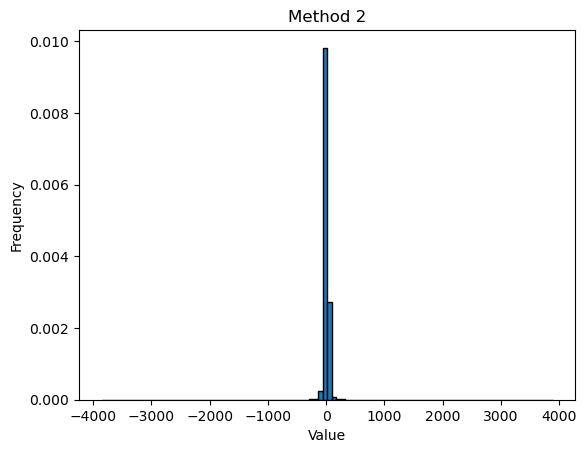

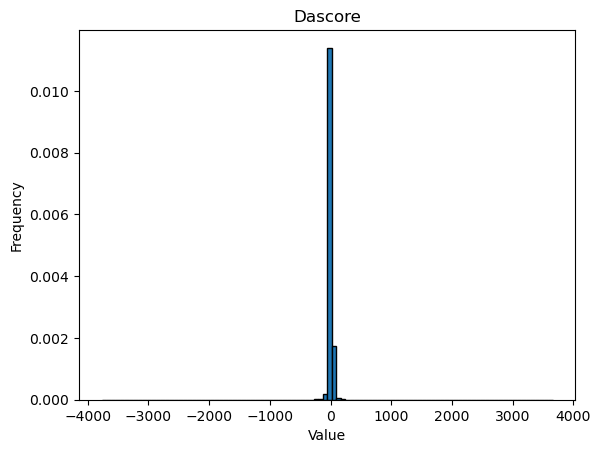

In [13]:
# Histogram of values in downsampled and regular signals
def plot_histogram(patch, title="Histogram of Patch Data", bins=50):
    data = patch.data
    plt.hist(data.flatten(), bins=bins, edgecolor='black', density=True)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Example usage
bins = 100
plot_histogram(patch_og, 'Original', bins)
plot_histogram(patch, "Method 1", bins)
plot_histogram(patch_m2, "Method 2", bins)
plot_histogram(decimated_patch, "Dascore", bins)

# Statistical tests

In [ ]:
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon, ttest_rel
from scipy.stats import chisquare

In [43]:
# Check if the distributions have the same mean
stat, p = ttest_ind(patch_og.data.flatten(), patch_m2.data.flatten(), equal_var=False)  # Set equal_var=True if variances are equal
print("p-value:", p)

if p > 0.05:
    print("Likely from the same distribution mean-wise.")
else:
    print("Likely from different distributions mean-wise")

p-value: 0.9999433067008285
Likely from the same distribution mean-wise.


In [44]:
# 2-Sample Kolmogoov-Smirnov Test
# This test might not make much sense since the assumption is that the data samples are independent, however
# the second signal is a subsample of the first one, so they are highly correlated. Moreover, subsampling
# changes the statistical properties of the signal, since high-frequency components are removed, lowering
# the variance, which implies the different distributions.

stat, p = ks_2samp(patch_og.data.flatten(), patch_m2.data.flatten())
if p > 0.05:
    print("Original and M2 likely from the same distribution")
else:
    print("Original and M2 likely from different distributions")

stat, p = ks_2samp(patch_og.data.flatten(), decimated_patch.data.flatten())
if p > 0.05:
    print("Original and Dascore likely from the same distribution")
else:
    print("Original and Dascore likely from different distributions")

Original and M2 likely from different distributions
Original and Dascore likely from different distributions


In [45]:
# Mann-Whitney U Test
stat, p = mannwhitneyu(patch_og.data.flatten(), patch_m2.data.flatten())
print("p-value:", p)

if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

p-value: 0.3793321749076791
Likely from the same distribution


In [46]:
# T-Test
stat, p = ttest_ind(patch_og.data.flatten(), patch_m2.data.flatten(), equal_var=False)  # Set equal_var=True if variances are equal
print("p-value:", p)

if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

p-value: 0.9999433067008285
Likely from the same distribution


In [51]:
# T-Test relative
stat, p = ttest_rel(patch_og.data[:,::2].flatten(), patch_m2.data.flatten())
print("p-value:", p)

if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

p-value: 0.35952979839200416
Likely from the same distribution


In [47]:
# Wilcoxon test
stat, p = wilcoxon(patch_og.data[:,::2].flatten(), patch.data.flatten())
print("p-value:", p)

if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

p-value: 0.6490779405004805
Likely from the same distribution


In [48]:
# Chisquare test
bins = 100
hist_og, bin_edges = np.histogram(patch_og.data.flatten(), bins=bins)
hist_m1 = np.histogram(patch.data.flatten(), bins=bin_edges)[0]
hist_m2 = np.histogram(patch_m2.data.flatten(), bins=bin_edges)[0]
hist_dc = np.histogram(decimated_patch.data.flatten(), bins=bin_edges)[0]

hist_og = hist_og/sum(hist_og)
hist_m1 = hist_m1/sum(hist_m1)
hist_m2 = hist_m2/sum(hist_m2)
hist_dc = hist_dc/sum(hist_dc)

print("METHOD 1:")
res = chisquare(hist_m1, hist_og)
stat, p = res.statistic, res.pvalue
print("Stat, p-value: ", stat, p)
if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

print("METHOD 2:")
res = chisquare(hist_m2, hist_og)
stat, p = res.statistic, res.pvalue
print("Stat, p-value: ", stat, p)
if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

print("METHOD DC:")
res = chisquare(hist_dc, hist_og)
stat, p = res.statistic, res.pvalue
print("Stat, p-value: ", stat, p)
if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

print("M2 - DC")
res = chisquare(hist_dc, hist_m2)
stat, p = res.statistic, res.pvalue
print("Stat, p-value: ", stat, p)
if p > 0.05:
    print("Likely from the same distribution")
else:
    print("Likely from different distributions")

METHOD 1:
Stat, p-value:  0.15424355682219287 1.0
Likely from the same distribution
METHOD 2:
Stat, p-value:  0.15424628239612434 1.0
Likely from the same distribution
METHOD DC:
Stat, p-value:  0.17973452454753583 1.0
Likely from the same distribution
M2 - DC
Stat, p-value:  0.0049076921517952 1.0
Likely from the same distribution
